# 與學習有關的技巧
本章要說明在神經網路的學中，成為關鍵的重要部分。本章挑選的主題包括，找出最佳參數的最佳化方法、權重參數的預設值、超參數的設定方法等，每個都是在神經網路的學中，十分重要的主題。另外，還會扼要說明執行Weight decay( 權重衰減 )與 Dropout 等正規化方法，當作過度學解決對策。最後，簡單說明近年來眾多研究中常用到的 Batch Normalization 手法，可以快速進行神經網路( 深度學習 )的學習。所以，讓我們開始本章的內容吧!


## 6.1 更新參數
神經網路的學習目的，就是找出可以盡量縮小損失函數的參數，亦即找出最佳參數。<br><br>

為了找出最佳化參數，計算了參數的梯度( 微分 )。重複執行利用參數的梯度，往梯度方向進行更新參數，最後會逐漸趨近最佳參數，這種方法稱作SGD，是非常單純的作法，但，還有比SGD更聰明的方法存在。以下要說明SGD的缺點，並介紹其他最佳化手法。


### 6.1.1 SGD
$
W ← W - \eta\frac{\partial{L}}{\partial{W}} \tag{6.1}
$
這裡的更新權重參數為$W$，損失函數的梯度為$\frac{\partial{L}}{\partial{W}}$。$\eta$代表學習率，實際上使用的是事先決定的0.01或0.001等數值。以下實現SGD。


In [2]:
class SGD:
    def __init__(self, lr = 0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


### 說明
初始化時的引數lr代表learning rate( 學習率 )，並且把學率當作實例變數。另外，還定義了update(self, params, grads)方法。在SGD中，會重複呼叫這個方法。我們來使用SGD看看。


### SGD的缺點
SGD很單純，也很容易執行，但遇到部分問題，可能會變得很沒有效率。以下將藉由思考函數最小值問題，指出SGD的缺點。<br>
$
f(x,y) = \frac{1}{20}x^2 + y^2 \tag{6.2}
$<br>
由算式可知，這個梯度的特色是，往$y$軸方向變大，往$x$軸方向就會變小。<br><br>

換句話說，SGD的缺點是，函數的形狀如果沒有**等向性**，非延伸形狀的函數，就會以沒有效率的路徑進行探索。為了改善SGD的缺點，接下來將介紹Momentum、AdaGrad、Adam等取代SGD的3種手法。


### 6.1.2 Momentum
Momentum的意思是「動量」與物理有關係。此手法可以用下列算式表示。<br>
$
v ← \alpha v - \eta\frac{\partial{L}}{\partial{W}} \tag{6.3}
$<br>
$
W ← W + v \tag{6.4}
$<br>
和前面的SGD一樣，$W$是更新的權重參數，$\frac{\partial{L}}{\partial{W}}$是與$W$有關的損失函數梯度，$\eta$代表學習率。這裡出現了新的變數$v$，站在物理的角度，$v$代表著「速度」。算式( 6.3 )代表，物體往梯度方向受力，並將這個力量加上物體速度$v$( 6.4 )的物理定律。<br>

另外，算式( 6.3 )還出現了$\alpha v$，這是當物體沒有受力時，逐漸減速的功能( $\alpha$ 設定為0.9等數值 )。站在物理學的角度，相當於地面磨擦力或是空氣阻力。以下是Momentum的執行過程。


In [3]:
import numpy as np
class Momentum:

    """Momentum SGD"""

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():                                
                self.v[key] = np.zeros_like(val)
                
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key] 
            params[key] += self.v[key]
        

### 6.1.3 AdaGrad
在神經網路的學習中，學習率的值分常重要( 算式中顯示為$\eta$ )。學習率太小，會花費太多時間浪費在學習上，反之則會無法正確學習。 <br><br>

有個學習率有關的有效技巧，稱為**學習率衰減( learning rate decay )** 逐漸降低學習率的概念，相當於統一降低參數「整個」學習率。進一步發展後，就成為AdaGrad，此手法為針對「每個」參數，準備「客製」值。<br><br>

AdaGrad是適應各個參數的元素，一邊調整學習率，一邊學習的手法( AdaGrad 的 Ada 為 Adaptive )。接下來，用算式來顯示AdaGrad的更新方法。<br>
$
h ← h + \frac{\partial{L}}{\partial{W}} \bigodot \frac{\partial{L}}{\partial{W}} \tag{6.5} 
$ <br>
$
W ← W -  \eta \frac{1}{\sqrt{h}} \frac{\partial{L}}{\partial{W}} \tag{6.6}
$ <br>

和前面的SGD一樣，$W$是更新的權重參數，$\frac{\partial{L}}{\partial{W}}$是與$W$有關的損失函數梯度，$\eta$代表學習率。這裡出現了新的變數$h$，如算式 ( 6.5 )所示，$h$維持為前面提到的梯度值平方和( 算式 ( 6.5 )的$\bigodot$代表矩陣各元素相乘再加總 )。更新參數時，乘上$\frac{1}{\sqrt{h}}$，調整學習規模。這是代表在參數的元素中，經常變動( 放大 )的元素，由於$h$在分母位置，因此學習率會因故而變小。由於經常變動的參數，學習率會逐漸變小，所以我們可以針對參數的各個元素，執行學習率衰減。接下來，我們來執行他。<br><br>

{Note} AdaGrad是把過去所有的梯度當作平方和，全都記錄下來。實際上，無限學習下去，更新量會變成0，完全不在更新。改善這個問題的手法，就是RMSPorp。其手法並非把過去所有的梯度一率加總，而是逐漸忘記過去的梯度，以大幅反應新梯度資料的方式加總。專有名詞稱作「指數移動平均」，以指數函數減少過去梯度的規模。


In [4]:
class AdaGrad:

    """AdaGrad"""

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


這裡必須注意到，最後一行加上了小數值1e-7這一點。這是為了避免當self.h[ key ]出現0時，發生除以0的問題。在大部分的深度學習框架中，這種小數值也可以設定成參數，這裡使用固定值1e-7。


### 6.1.4 Adam
Momentum是依照球在碗內來回滾動的物理定律為基準來移動，而AdaGrad是依照各個參數的元素，調整適應的更新步驟。假如將Momentum與AdaGrad相結合，就是Adam了!<br><br>

直覺來說，結合以上兩種手法的優點，可以有效探索參數空間。另外，還能進行超參數的「偏權值調整( 偏離校正 )」，這也是Adam的特色之一。接下來我們來執行他。


In [5]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)


### 6.1.5 利用MNIST資料集比較更新手法
以下將以手寫辨識數字為對象，比較前面說明過的SGD、Momentum、AdaGrad、Adam等4種手法。確認每種手法的學習進展有何不同。<br>


===========iteration:0===========
SGD:2.3356935499363285
Momentum:2.3495937688707484
AdaGrad:2.2599566969872518
Adam:2.1726558339233732
===========iteration:100===========
SGD:1.433366440829821
Momentum:0.24454484979976798
AdaGrad:0.07795337499657798
Adam:0.18928479637271092
===========iteration:200===========
SGD:0.7557511755448117
Momentum:0.5039164917349346
AdaGrad:0.2647517351458038
Adam:0.4456197911372994
===========iteration:300===========
SGD:0.46452218201283313
Momentum:0.2523405908995795
AdaGrad:0.08783347095228952
Adam:0.15422570283039708
===========iteration:400===========
SGD:0.4704174609772213
Momentum:0.3013551476211603
AdaGrad:0.17092248345181155
Adam:0.2281373125609128
===========iteration:500===========
SGD:0.2867959998810909
Momentum:0.104164275617434
AdaGrad:0.03409116284227293
Adam:0.08045520347736985
===========iteration:600===========
SGD:0.3759763648898215
Momentum:0.15358101654230238
AdaGrad:0.05695617243652647
Adam:0.1110610053890109
===========iteration:700===

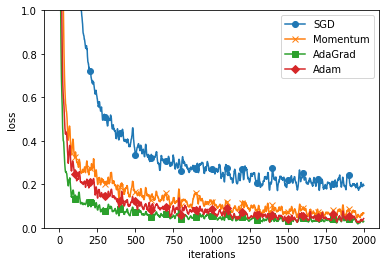

In [6]:
import sys, os
sys.path.append(os.path.abspath('./dl_ex')) #載入父目錄檔案的設定
import numpy as np
import matplotlib.pyplot as plt
from dl_ex.dataset.mnist import load_mnist
from dl_ex.ch05.two_layer_net import TwoLayerNet
from dl_ex.common.util import smooth_curve
from dl_ex.common.multi_layer_net import MultiLayerNet
from dl_ex.common.optimizer import *

# 0:MNIST載入
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1:實驗設定
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:開始學習
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3.繪圖
%matplotlib inline
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


由圖可以看出，除了SGD外的3種手法的學速度的確較快，有時最後的辨識效能也比較好。


## 6.2 權重的預設值
在神經網路中，特別重要的就是權重的預設值。事實上，權重的預設值應該設定為哪種數值，常會影響到神經網路的學習成功與否。本節將針對建議的權重預設值來說明，利用實驗，確認實際的神經網路學習速度。<br><br>


### 6.2.1 權重的預設值變成0?
後面將會介紹 Weight decay ( 權重衰減 )手法，當作控制過度學習，提高一般化功能的技巧。其是以縮小權重參數值為目的，進行學習的手法。縮小權重值，可以避免過度學習。<br><br>

如果想要縮小權重值，預設值也盡量從小數值開始，這是屬於正攻法。想要縮小權重值，把權重的預設值全部設為0呢?其實，這是一個糟糕的想法，因為如此會造成不正確學習。<br><br>

為什麼預設值不能設為均一值(或是全部為0)?因為誤差反向傳播法中，所有的權重值都會均一更新。假設在雙層神經網路中，把第1層與第2層的權重設定為0，進行正向傳播時，因為輸入層的權重為0，會傳遞相同值給第2層神經元。第2層神經元全部輸入相同的值，在反向傳播時，第2層的權重會更新成一樣。因此，我們需要的是隨機的預設值。

### 6.2.2 隱藏層的活性化分布
觀察隱藏層的活性化，可以得到許多資料。以下進行一個簡單的實驗，觀察隱藏層的活性化會隨著權重的預設值產生何種變化。這裡進行的實驗室，在5層的神經網路中(活化函數使用Sigmoid函數)，傳遞隨機產生的輸入資料，利用分布圖繪製各層的活性化資料分布。

{Note} 這裡把活化函數之後的輸出資料稱為「活性化( Activation )」，但是根據文獻紀載，在各層之間流動的資料，稱可稱為活性化。


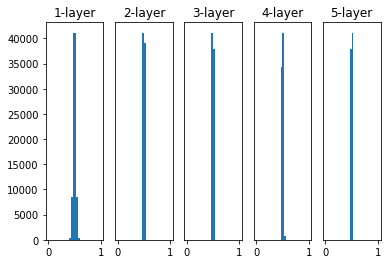

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100)  # 1000個輸入資料
node_num = 100  # 各隱藏層的神經元數目
hidden_layer_size = 5  # 5層隱藏層
activations = {}  # 放置活性化資料的地方

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 隨機產生的初始權重預設值！
    # w = np.random.randn(node_num, node_num) * 1
    w = np.random.randn(node_num, node_num) * 0.01 # 隨機初始化使用標準差為0.01的常態分配
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) 
    # w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)


    a = np.dot(x, w)


    # 活性化開始！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z

# 繪圖
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


如圖所示，能看出各層的活性化分布偏向0與1。這裡使用的Sigmoid函數為呈現s型曲線的函數，但隨著sigmoid函數的輸出趨近於0(或1)，該微分值也會趨近於0。因此，在偏向0與1的資料分布中，反向傳播的梯度值會逐漸變小、消失。這就是所謂的「梯度消失( gradient vanishing )」問題。在層數多的深度學習中，梯度消失會造成嚴重的問題。<br><br>

然而，若我們使用sd為0.01的常態分配做模擬，會發現集中分配在0.5附近。和前面偏向0與1不同，沒有引起梯度消失問題。可是，活性化分布出現特定偏差，在表現力方面，將會產生重大問題。因為，當多個神經元輸出幾乎一模一樣的數值時，就沒有存在的意義。例如，100個神經元的輸出幾乎相同數值，代表只用1個神經元，就能表現出一樣的情況。因此，活性化分布若出現偏差情況，會有「表現力受限」的問題，造成無法正確學習。因此我們需要在各層傳遞具有適當多樣性的資料。因此隨機初始化方法3、4為較佳的候選方法!!


### 6.2.3 利用MNIST資料集比較權重預設值
讓我們以實際資料為對象，提供不同的權重預設值，檢視對神經網路的學會造成何種影響。以下利用「std = 0.01」、「Xavier預設值」、「He預設值」等三種情況來進實驗。


===========iteration:0===========
std=0.01:2.3025329223238584
Xavier:2.3068515898035553
He:2.4803015208507606
===========iteration:100===========
std=0.01:2.302152343471332
Xavier:2.2519702797836554
He:1.5175834266480537
===========iteration:200===========
std=0.01:2.302735264092607
Xavier:2.098144666711304
He:0.7319833573173076
===========iteration:300===========
std=0.01:2.3021582359645043
Xavier:1.8847973160874443
He:0.5534199831863598
===========iteration:400===========
std=0.01:2.302234000741027
Xavier:1.4447272489606915
He:0.4889689942370519
===========iteration:500===========
std=0.01:2.3018832368353483
Xavier:0.9843404103452786
He:0.4049719497431833
===========iteration:600===========
std=0.01:2.302756489715163
Xavier:0.6522214689907871
He:0.1963144278841546
===========iteration:700===========
std=0.01:2.2961485640148056
Xavier:0.5169310970117199
He:0.3096802886582701
===========iteration:800===========
std=0.01:2.3002897065552235
Xavier:0.4507267570528286
He:0.2260211763418029

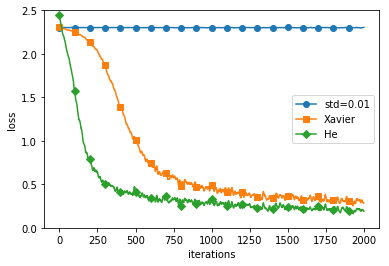

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# 0:載入MNIST
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# 1:權重預設值設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

# 2:開始訓練==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))

# 3.繪圖==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()


### 權重預設值的重要性
如圖，在這實驗中以5層神經網路為對象(各層有100個神經元)，使用ReLU當作活化函數。由結果可知，當「std=0.01」時，完全不會學習。因為正向傳播的數值非常小，集中在0(6.2.2小節有介紹)使得反向傳播時，計算的梯度也會變小，因而幾乎不會更新權重。相對來說「Xavier」、「He」預設值可以順利學習，且似乎He預設值表現較佳，學習速度較快。


## 6.3 Batch Normalization
在上一節，我們觀察了各層的活性化分布。這裡學到的重點是，只要妥善設定權重的預設值，就能讓各層的活性化分布具有適當廣度(神經元的多樣性)，就能順利進行學習。然而，為何我們不「強制性」調整活性化的分布?其實，以這種概念為基礎的手法，稱作Batch Normalization。


### 6.3.1 Batch Normalization演算法
Batch Normalization為2015年提出的方法，是很新的手法；但事實上，檢視ML的競賽結果，利用Batch Norm的優秀的成果案例比比皆是。<br><br>

為何 Batch Norm 如此受到矚目? 我們來看看他的優點。<br>
* 可以快速學習(因為能增加學習率)
* 不會過度依賴預設值( 不會對預設值產生過度反應 )
* 控制過度學習( 減少對Dropout等必要性 )
<br><br>

Batch Norm的概念如前所述，可以調整各層的活性化分布，變得具有適當廣泛性(神經元多元性)。因此，這裡把進行資料分布正規化的層級，即 Batch Normalization層，插入神經網路中，如圖所示。<br>
![6.3.1 Batch Normalization神經網路範例](./img/6.3.1.PNG)<br><br>

Batch Norm顧名思義，就是在進行學習時，以小批次為單位，依照各個小批次來進行正規化，就是進行讓資料分布平均為0，分散為1的正規化處理，以下說明算式。<br><br>

$
\mu _B ← \frac{1}{m} \sum _{i=1}^k xi 
$<br>

$
\sigma_B^2 ← \frac{1}{m} \sum_{i=1\atop k}(x_{i} - \mu_b)^2 \tag{6.7}
$<br>
$
\hat{x_i} ← \frac{x_i-\mu_B}{\sqrt{\sigma_B^2+\epsilon}}
$<br><br>

這裡針對m個小批次B = {$x_1, \cdots{, x_m}$}

